In [385]:
#Inital imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes.plotting import plot_period_transactions, plot_calibration_purchases_vs_holdout_purchases
from lifetimes import BetaGeoFitter, GammaGammaFitter
from datetime import timedelta
from datetime import datetime
from dateutil import parser
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [2]:
!ls data

OnlineRetail_2yrs.csv             lifetimes_object_df.csv
customer_data_base.zip            lifetimes_object_df_uncleaned.csv


In [73]:
#Load in our pre-prepared dataframes
lifetimes_object_df = pd.read_csv("data/lifetimes_object_df.csv")

### Preparation and evaluation functions

In [4]:
#Load in our data wrangler
from lifetimes.utils import summary_data_from_transaction_data
#Import holdout 
from lifetimes.utils import calibration_and_holdout_data

In [53]:
def clean_transaction_csv(csv,purchase_timestamp_col,customer_id_col,datetime_col,monetary_value_col):
    lifetimes_object_df = pd.read_csv(csv)
    #Remove tansactions less than or equal to zero
    lifetimes_object_df = lifetimes_object_df[lifetimes_object_df[monetary_value_col]>0]
    #Subset to only repeat customers
    repeat_cust_ID = lifetimes_object_df.groupby(customer_id_col).count()
    repeat_cust_ID = list(repeat_cust_ID[repeat_cust_ID[datetime_col]>1].index)
    lifetimes_object_df = lifetimes_object_df[lifetimes_object_df[customer_id_col].isin(repeat_cust_ID)]
    #convert datetime_col to datetime64
    lifetimes_object_df[datetime_col] = pd.to_datetime(lifetimes_object_df[datetime_col])
    #return a df with only repeat customers with orders over 0.00 monetary value
    return lifetimes_object_df

In [5]:
#class to return a calibration and holdout df
class df_ch():
    def __init__(self, eval_period=None,transaction_df=None,purchase_timestamp_col=None,customer_id_col=None,datetime_col=None,monetary_value_col=None):
        #initialized attributes
        self.eval_period = eval_period
        self.transaction_df = transaction_df
        self.purchase_timestamp_col=purchase_timestamp_col
        self.customer_id_col=customer_id_col
        self.datetime_col=datetime_col
        self.monetary_value_col=monetary_value_col
        #save off more attributes
        self.min_obs_date = parser.parse(transaction_df[purchase_timestamp_col].min())
        self.max_obs_date = parser.parse(transaction_df[purchase_timestamp_col].max())
        self.max_calib_date = self.max_obs_date - timedelta(days=eval_period)  
        self.calib_range_days = (self.max_calib_date - self.min_obs_date).days
    def df_ch_getdf(self):
        df = calibration_and_holdout_data(
        transactions = self.transaction_df, 
        customer_id_col=self.customer_id_col,
        datetime_col=self.datetime_col,
        monetary_value_col=self.monetary_value_col,
        calibration_period_end = self.max_calib_date, 
        observation_period_end = self.max_obs_date, 
        freq = "D")
        return df
        

In [6]:
#function to return a df of real and predicted transacitons in eval period
def bgf_real_v_pred_df(ch,bgf):
    rfm_cal_holdout = pd.DataFrame()
    ch_df = ch.df_ch_getdf()
    rfm_cal_holdout["n_transactions_cal_real"]  = ch_df["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    rfm_cal_holdout["n_transactions_holdout_real"]  = ch_df["frequency_holdout"] #Total validation days with purchases = validation frequency
    # the predicted number of transactions
    rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=ch.eval_period, 
                                                    frequency=ch_df['frequency_cal'], 
                                                    recency=ch_df['recency_cal'], 
                                                    T=ch_df['T_cal'])
    return rfm_cal_holdout[["n_transactions_cal_real","n_transactions_holdout_real", "n_transactions_holdout_pred"]]

In [240]:
#function to capture RMSE for a BGF model
def bgf_rmse(ch,bgf):
    df_ch = ch.df_ch_getdf()
    df_ch["n_transactions_holdout_real"] = df_ch["frequency_holdout"]
    y_true = df_ch["n_transactions_holdout_real"]
    y_pred = bgf.predict(t=ch.eval_period, frequency=df_ch['frequency_cal'],
                         recency=df_ch['recency_cal'],
                         T=df_ch['T_cal'])

    return mean_squared_error(y_true,y_pred,squared=False)

In [241]:
#function to return predicted # transactions for given customer in evaluation period
def samp_cust_pred_trans(df_ch,sample_customer_id,eval_period):
    sample_customer = df_ch.loc[sample_customer_id]
    n_transactions_pred = bgf.predict(t=eval_period,
                                  frequency=sample_customer['frequency_cal'], 
                                  recency=sample_customer['recency_cal'], 
                                  T=sample_customer['T_cal'])
    return(n_transactions_pred)

In [263]:
#Dummy model function that predicts the same purchase rate in the observation period to continue through the eval period
def bgf_dummy_model(ch):
    df_ch = ch.df_ch_getdf()
    dummy_ch_df = pd.DataFrame()
    dummy_ch_df["purchases_per_period_cal"] = df_ch["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch.calib_range_days #Purchase rate
    dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch.eval_period #Predicting purchase rate to continue
    dummy_ch_df["dummy_pred_purchases_holdout"] = np.round(dummy_ch_df["dummy_pred_purchases_holdout"]) #Round to get an actual number of predictions
    dummy_ch_df["actual_purchases_holdout"] = df_ch["frequency_holdout"] #Total validation days with purchases = validation frequency
    return mean_squared_error(y_true=dummy_ch_df["dummy_pred_purchases_holdout"],y_pred=dummy_ch_df["actual_purchases_holdout"],squared=False)


In [243]:
#function to return a df of real and predicted transacitons in eval period for dummy model
def bgf_dummy_real_v_pred_df(ch):
    df_ch = ch.df_ch_getdf()
    dummy_ch_df = pd.DataFrame()
    dummy_ch_df["purchases_per_period_cal"] = df_ch["frequency_cal"] + 1 #Total calibration days with purchases = calibration frequency + 1
    dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch.calib_range_days #Purchase rate
    dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch.eval_period #Predicting purchase rate to continue
    dummy_ch_df["actual_purchases_holdout"] = df_ch["frequency_holdout"] #Total validation days with purchases = validation frequency
    return dummy_ch_df

### RFM data exploration 

In [244]:
summary = summary_data_from_transaction_data(transactions=lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value',observation_period_end='2018-10-17')
summary

,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,160.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,163.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,586.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,370.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,337.0,0.0
...,...,...,...,...
fffcf5a5ff07b0908bd4e2dbc735a684,0.0,0.0,496.0,0.0
fffea47cd6d3cc0a88bd621562a9d061,0.0,0.0,311.0,0.0
ffff371b4d645b6ecea244b27531430a,0.0,0.0,617.0,0.0


In [245]:
#We have less than 3% of customers who are repeat purchasers
summary.frequency.value_counts(normalize=True)

0.0     0.978261
1.0     0.020097
2.0     0.001305
3.0     0.000189
4.0     0.000063
5.0     0.000053
6.0     0.000021
15.0    0.000011
Name: frequency, dtype: float64

In [246]:
#These customers cannot be used for analysis in your GG model bc they don't have repeat purchases
print(f'customers without repeat purchases: {summary.frequency.value_counts()[0]}')

customers without repeat purchases: 92924


In [247]:
#create a list of repeat purchasers
repeat_purchaser_ids = list(summary[summary["frequency"] >= 1].index)
#subset our transaction data to just repeat purchasers
repeat_lifetimes_object_df = lifetimes_object_df[lifetimes_object_df["customer_unique_id"].isin(repeat_purchaser_ids) == True]
#repeat_lifetimes_object_df["order_purchase_timestamp"] = pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"])
#Checking we removed the correct number of user id's
(len(lifetimes_object_df.customer_unique_id.unique()) - len(repeat_lifetimes_object_df.customer_unique_id.unique())) == summary.frequency.value_counts()[0]


True

In [248]:
repeat_purchaser_summary = summary_data_from_transaction_data(transactions=repeat_lifetimes_object_df,customer_id_col='customer_unique_id',
                                             datetime_col='order_purchase_timestamp',monetary_value_col='payment_value')


In [249]:
#Calculate the time between purchases
inter_purchase_period = []
for customer in repeat_purchaser_summary.index:
    inter_purchase_period.append((repeat_purchaser_summary.loc[customer].recency/repeat_purchaser_summary.loc[customer].frequency))
avg_inter_purchase_period = sum(inter_purchase_period)/len(inter_purchase_period)
avg_inter_purchase_period

113.9720823244552

In [250]:
#From the documentation, for optimal fit, the training date range should cover at least 3 
#but hopefully 5-10 inter-purchase periods
#The holdout period should be at least half the training period
total_date_range = (pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"]).max() - pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"]).min()).days
total_date_range

700

In [251]:
# An inter_period_multiple of 4 works well and gives us a holdout period of about 240 days
inter_period_multiple = 4
print(f'holdout period given {inter_period_multiple} inter period multiple: {total_date_range-(avg_inter_purchase_period*4)}')

holdout period given 4 inter period multiple: 244.1116707021792


In [252]:
#The Gamma-Gamma submodel, assumes no relationship between the monetary value and the purchase frequency. 
#The correlation between the two vectors is close to 0 so we can use this model.
repeat_purchaser_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.00000,-0.00049
frequency,-0.00049,1.00000


In [253]:
#Load in our ch object with all data
ch_1 = df_ch(eval_period=240,transaction_df=lifetimes_object_df,purchase_timestamp_col='order_purchase_timestamp',
                   customer_id_col='customer_unique_id',datetime_col='order_purchase_timestamp',
                   monetary_value_col='payment_value')

In [254]:
#Load in our ch object with repeat purchaser data
ch_2 = df_ch(eval_period=240,transaction_df=repeat_lifetimes_object_df,purchase_timestamp_col='order_purchase_timestamp',
                   customer_id_col='customer_unique_id',datetime_col='order_purchase_timestamp',
                   monetary_value_col='payment_value')

In [255]:
#create an array to evaluate total purchases per customer in calib period
repeat_lifetimes_object_df_ts = repeat_lifetimes_object_df
repeat_lifetimes_object_df_ts["order_purchase_timestamp"] = pd.to_datetime(repeat_lifetimes_object_df["order_purchase_timestamp"])
purchases_in_cal = repeat_lifetimes_object_df_ts[repeat_lifetimes_object_df_ts["order_purchase_timestamp"]<=ch_2.max_calib_date]
purchases_in_cal = purchases_in_cal[purchases_in_cal["order_purchase_timestamp"]<=ch_2.max_calib_date].groupby("customer_unique_id").nunique()["order_purchase_timestamp"]
purchases_in_cal.sort_values()
purchases_in_cal = pd.DataFrame(purchases_in_cal)
purchaser_id_in_cal = list(purchases_in_cal.index)

In [256]:
#create an array to evaluate total purchases per customer in validation period
purchases_in_val = repeat_lifetimes_object_df_ts[repeat_lifetimes_object_df_ts["order_purchase_timestamp"]>ch_2.max_calib_date].groupby("customer_unique_id").nunique()["order_purchase_timestamp"]
purchases_in_val.sort_values()
purchases_in_val = pd.DataFrame(purchases_in_val)
#subset to just those id's that appeared in our calib period
purchases_in_val = purchases_in_val[purchases_in_val.index.isin(purchaser_id_in_cal)]

In [257]:
#Get ch df from repeat purchaser ch object
df_ch_2 = ch_2.df_ch_getdf()

In [258]:
#Confirming that a 'frequency' of 0.00 in calibration period means total purchases in that period = 1
#Total calibration days with purchases = calibration frequency + 1
purch = []
for purchasers in df_ch_2["frequency_cal"]:    
    purch.append(purchasers+1)
sum(purch) == purchases_in_cal["order_purchase_timestamp"].sum()

True

In [259]:
#Attempting on holdout group
#False bc these are repeat customers so we don't need to add +1
purch = []
for purchasers in df_ch_2["frequency_holdout"]:    
    purch.append(purchasers+1)
sum(purch) == purchases_in_val["order_purchase_timestamp"].sum()

False

In [260]:
#Total validation days with purchases = validation frequency
sum(df_ch_2["frequency_holdout"]) == purchases_in_val["order_purchase_timestamp"].sum()

True

###  Dummy model
Model features
- Predict purchases in holdout period based on the observed purchase rate in the calibration period

Model results
- Decent RMSE for all customers
- Poor RMSE for repeat customer subset
- The dummy model expects purchase rate to continue so you see it do very poorly predicting actual purchase rate for customers who had just one purchase in the calibration period.

In [265]:
print(f' bgf dummy model RMSE w/ all data: {bgf_dummy_model(ch_1)}')
print(f' bgf dummy model RMSE w/ repeat cust only: {bgf_dummy_model(ch_2)}')

 bgf dummy model RMSE w/ all data: 0.18670952242425554
 bgf dummy model RMSE w/ repeat cust only: 0.8206158691033689


In [266]:
#Return a dataframe with predicted and actual values using dummy model on repeat customers
dummy_ch_df = pd.DataFrame()
dummy_ch_df["frequency_cal"] = df_ch_2["frequency_cal"]
#Add 1 to frequency to get total purchasers in calibration period
dummy_ch_df["purchases_per_period_cal"] = df_ch_2["frequency_cal"] + 1
#divide by purchases by n calibration days to get purchase rate
dummy_ch_df["purchases_per_period_cal"] = dummy_ch_df["purchases_per_period_cal"]/ch_2.calib_range_days
#multiply purchase rate by n evaluation days to get purchase per day
dummy_ch_df["dummy_pred_purchases_holdout"] = dummy_ch_df["purchases_per_period_cal"] * ch_2.eval_period
#Round the prediction to get an integer, purchases either happen or they don't
dummy_ch_df["dummy_pred_purchases_holdout"] = np.round(dummy_ch_df["dummy_pred_purchases_holdout"])
#Get actual purchases in validation period
dummy_ch_df["actual_purchases_holdout"] = df_ch_2["frequency_holdout"]

In [267]:
#There are so few examples of customers with more than 4 purchases in the calibaration period that we should limit our
#evaluation to 4 or fewer
dummy_ch_df.groupby("frequency_cal").count()

,purchases_per_period_cal,dummy_pred_purchases_holdout,actual_purchases_holdout
frequency_cal,,,
0.0,623,623,623
1.0,711,711,711
2.0,38,38,38
3.0,9,9,9
4.0,2,2,2
8.0,1,1,1


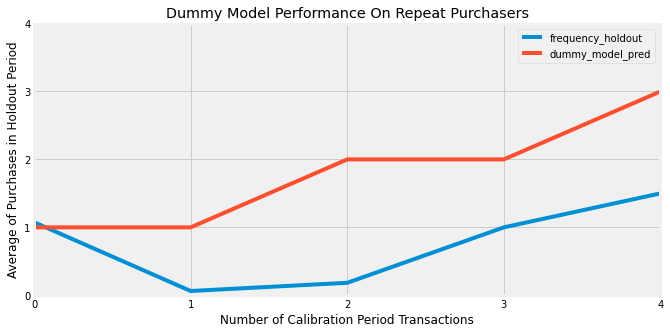

In [391]:
#Plot a visual to demonstrate dummy model performance
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dummy_ch_df.groupby("frequency_cal").mean()["actual_purchases_holdout"],label=('frequency_holdout'))
ax.plot(dummy_ch_df.groupby("frequency_cal").mean()["dummy_pred_purchases_holdout"],label=('dummy_model_pred'))
ax.set_xlabel("Number of Calibration Period Transactions")
ax.set_ylabel("Average of Purchases in Holdout Period")
ax.set_title("Dummy Model Performance On Repeat Purchasers")
ax.set_xticks([0,1,2,3,4])
ax.set_xlim(0,4)
ax.set_yticks([0,1,2,3,4])
ax.set_ylim(0,4)

ax.legend()
#Save figure as png
plt.savefig("visuals/dummy_model_performance_repeat_purchasers.png");

###  1.0 BG/NBD model
Model features
- All customers including those with just 1 purchase

Model results
- Very strong RMSE
- We significantly improved upon our dummy model
- Our model doesn't suffer from the niave assumption that purchase rate will just continue

Next steps
- Attempt on subsetted data of customers with more than 1 purchase

In [269]:
#Iniatialze df_ch 
df_ch_1 = ch_1.df_ch_getdf()

In [270]:
#Iniatialize bgf model
bgf_1 = BetaGeoFitter(penalizer_coef=0)

In [271]:
#Fit model to df_ch
bgf_1.fit(
        frequency = df_ch_1["frequency_cal"], 
        recency = df_ch_1["recency_cal"], 
        T = df_ch_1["T_cal"],   
        weights = None,  
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.065817
         Iterations: 60
         Function evaluations: 63
         Gradient evaluations: 63


<lifetimes.BetaGeoFitter: fitted with 44463 subjects, a: 1.85, alpha: 55.22, b: 0.32, r: 0.02>

In [272]:
#Return rmse for first model
bgf_1_rmse = bgf_rmse(ch_1,bgf_1)
bgf_1_rmse

0.1423220657607575

In [273]:
#There are so few examples of customers with more than 4 purchases in the calibaration period that we should limit our
#evaluation to 4 or fewer
df_ch_1.groupby("frequency_cal").count()

,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
frequency_cal,,,,,,
0.0,43702,43702,43702,43702,43702,43702
1.0,711,711,711,711,711,711
2.0,38,38,38,38,38,38
3.0,9,9,9,9,9,9
4.0,2,2,2,2,2,2
8.0,1,1,1,1,1,1


/Applications/anaconda3/envs/lifetime-env/lib/python3.10/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)
/Applications/anaconda3/envs/lifetime-env/lib/python3.10/site-packages/lifetimes/generate_data.py:54: RuntimeWarning: overflow encountered in double_scalars
  next_purchase_in = random.exponential(scale=1.0 / l)


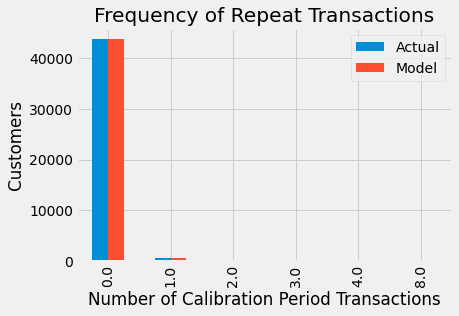

In [379]:
#Our model accurately esimates n purchases with in the calibation period
plot_period_transactions(bgf_1);

<Figure size 720x360 with 0 Axes>

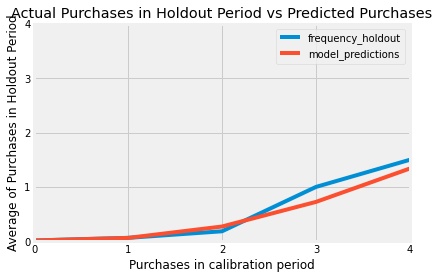

In [390]:
# testing: predicted vs actual purchases in holdout period
fig = plt.figure(figsize=(10, 5)) 
fig = plot_calibration_purchases_vs_holdout_purchases(bgf_1, df_ch_1)

fig.set_xticks([0,1,2,3,4])
fig.set_xlim(0,4)
fig.set_yticks([0,1,2,3,4])
fig.set_ylim(0,4);

###  2.0 BG/NBD model
Model features
- Subsetted data of customers with more than 1 purchase

Model results
- This is our best model
- Our model is less accurate on this subset of repeat customers bc we can't inflate accuracy with the signficant n of correct 0 purchase perdictions that 
- That said, this model did much better than our dummy model did on repeat customers

Next steps
- Attempt regularization

In [276]:
#Iniatialze df_ch 
df_ch_2 = ch_2.df_ch_getdf()

In [277]:
#Iniatialize bgf model
bgf_2 = BetaGeoFitter(penalizer_coef=0)

In [278]:
#Fit model to df_ch
bgf_2.fit(
        frequency = df_ch_2["frequency_cal"], 
        recency = df_ch_2["recency_cal"], 
        T = df_ch_2["T_cal"],   
        weights = None,  
        verbose = True)

Optimization terminated successfully.
         Current function value: 0.095057
         Iterations: 29
         Function evaluations: 31
         Gradient evaluations: 31


<lifetimes.BetaGeoFitter: fitted with 1384 subjects, a: 1.82, alpha: 135.02, b: 0.25, r: 1.13>

In [280]:
bgf_2_rmse = bgf_rmse(ch_2,bgf_2)
bgf_2_rmse

0.5049712698648924

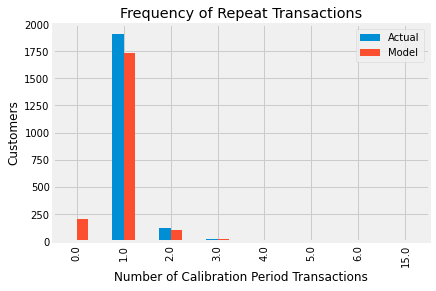

In [389]:
plot_period_transactions(bgf_2);

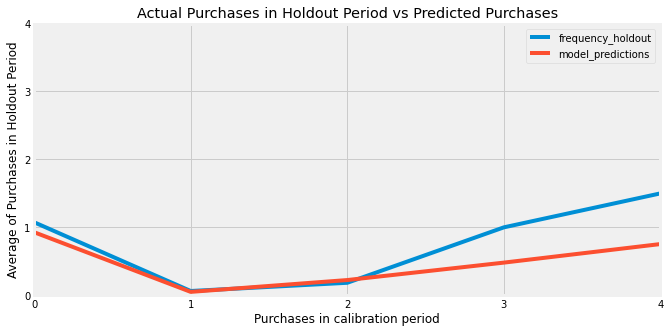

In [406]:
# testing: predicted vs actual purchases in holdout period 
fig = plot_calibration_purchases_vs_holdout_purchases(bgf_2, df_ch_2,figsize=(10, 5))
fig.set_xticks([0,1,2,3,4])
fig.set_xlim(0,4)
fig.set_yticks([0,1,2,3,4])
fig.set_ylim(0,4);
#Save figure as png
plt.savefig("visuals/final_bgf_model_performance.png");

###  3.0 BG/NBD model
Model features
- Subsetted data of customers with more than 1 purchase
- Regularization in the form of l2 penalty

Model results
- Zero regularization produced the best result

Next steps
- Attempt regularization on full data set

In [282]:
#Documentation says that penalties in the order of 0.001 to 0.1 are effective
penalizer_coef_grid = {"bgf_3_0":0,"bgf_3_001":0.001,"bgf_3_05":0.05,"bgf_3_01":.01,"bgf_3_015":.015}
for penalizer in penalizer_coef_grid:
    model = BetaGeoFitter(penalizer_coef=penalizer_coef_grid[penalizer])
    model.fit(
        frequency = df_ch_2["frequency_cal"], 
        recency = df_ch_2["recency_cal"], 
        T = df_ch_2["T_cal"],   
        weights = None,  
        verbose = False)
    print(f'{penalizer} {bgf_rmse(ch_2,model)}')

bgf_3_0 0.5049712698648924
bgf_3_001 0.5054428215807601
bgf_3_05 0.6197923245381787
bgf_3_01 0.543172978035297
bgf_3_015 0.5577988977075885


###  4.0 BG/NBD model
Model features
- All customers including those with just 1 purchase
- Regularization in the form of l2 penalty

Model results
- Zero regularization produced the best result

Next steps
- Bring in a Gama Gama model to predict LTV using our best model that has 0 regularization


In [204]:
for penalizer in penalizer_coef_grid:
    model = BetaGeoFitter(penalizer_coef=penalizer_coef_grid[penalizer])
    model.fit(
        frequency = df_ch_1["frequency_cal"], 
        recency = df_ch_1["recency_cal"], 
        T = df_ch_1["T_cal"],   
        weights = None,  
        verbose = False)
    print(f'{penalizer} {bgf_rmse(ch_1,model)}')

bgf_3_0 0.020255570402409388
bgf_3_001 0.02159426531842805
bgf_3_05 0.026885903278818842
bgf_3_01 0.024215553556762578
bgf_3_015 0.024818318495397666


###  1.0 GG model
Model features
- Customers with monetary values in training and validation periods
- Minimal regularization

Model results
- Pretty good RMSE of less than $10


In [322]:
#Subset our data-set to ensure there are monetary values in both calibration and holdout periods
df_ch_2_subset = df_ch_2[df_ch_2["monetary_value_cal"]>0]
df_ch_2_subset = df_ch_2_subset[df_ch_2_subset["monetary_value_holdout"]>0]
df_ch_2_subset.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
customer_unique_id,,,,,,,
041caba6a63ace5818387698ea85cdb2,1.0,247.0,297.0,51.73,1.0,71.78,240.0
083ca1aa470c280236380973a48f77c6,2.0,19.0,162.0,86.96,1.0,105.29,240.0
0b18593e033697810a62a987e77f4b8c,1.0,12.0,218.0,73.34,1.0,63.13,240.0
1b6c7548a2a1f9037c1fd3ddfed95f33,4.0,37.0,54.0,138.31,2.0,176.81,240.0
1da09dd64e235e7c2f29a4faff33535c,1.0,71.0,241.0,859.36,1.0,830.64,240.0


In [327]:
#Fitting our model using a minimal penalizer
gg_1 = GammaGammaFitter(penalizer_coef = 0.001)
gg_1.fit(frequency=df_ch_2_subset["frequency_cal"],monetary_value=df_ch_2_subset["monetary_value_cal"])

<lifetimes.GammaGammaFitter: fitted with 51 subjects, p: 10.43, q: 1.27, v: 9.91>

In [328]:
predicted_monetary_value = gg_1.conditional_expected_average_profit(frequency=df_ch_2_subset["frequency_holdout"],monetary_value=df_ch_2_subset["monetary_value_holdout"])
predicted_monetary_value.describe()

count     51.000000
mean     138.458452
std      136.872379
min       43.713787
25%       68.512605
50%      100.035614
75%      143.295964
max      819.621051
dtype: float64

In [329]:
#Return mean squared error
mean_squared_error(y_true=df_ch_2_subset["monetary_value_holdout"],y_pred=gg_1.conditional_expected_average_profit(frequency=df_ch_2_subset["frequency_holdout"],monetary_value=df_ch_2_subset["monetary_value_holdout"]),squared=False)

6.6272680278896345

### Predicting LTV For Return Customers

In [489]:
#subset the summary data to just return customers, GG models do not accept a freq of zero
return_cust_summary = summary[summary["frequency"]>0]
#fit the GG model
final_gg = GammaGammaFitter(penalizer_coef = 0.001)
final_gg.fit(return_cust_summary['frequency'],
        return_cust_summary['monetary_value'])
#We can now estimate the average transaction value:
ggf.conditional_expected_average_profit(
        return_cust_summary['frequency'],
        return_cust_summary['monetary_value']).head()


customer_unique_id
004288347e5e88a27ded2bb23747066c    110.371683
004b45ec5c64187465168251cd1c9c2f     58.272043
00a39521eb40f7012db50455bf083460     35.776466
011575986092c30523ecb71ff10cb473     87.983367
011b4adcd54683b480c4d841250a987f    155.811383
dtype: float64

In [497]:
#Now we'll estimate LTV over the next 12 months
prediction_period = 12
# refit the bgf model to the full return customer data-set
bgf_2.fit(return_cust_summary['frequency'], return_cust_summary['recency'], return_cust_summary['T'])

ltv_predictions = final_gg.customer_lifetime_value(
    bgf_2, #our best bgf model
    return_cust_summary['frequency'],
    return_cust_summary['recency'],
    return_cust_summary['T'],
    return_cust_summary['monetary_value'],
    time=prediction_period, # months
    discount_rate=0.0, # monthly discount rate ~ 12.7% annually
    freq ="D"
)
ltv_predictions

customer_unique_id
004288347e5e88a27ded2bb23747066c     1.409494
004b45ec5c64187465168251cd1c9c2f     2.254568
00a39521eb40f7012db50455bf083460     1.340857
011575986092c30523ecb71ff10cb473     2.268554
011b4adcd54683b480c4d841250a987f     2.587308
                                      ...    
fed519569d16e690df6f89cb99d4e682     2.361546
ff03923ad1eb9e32304deb7f9b2a45c9     4.613806
ff22e30958c13ffe219db7d711e8f564    14.792828
ff8892f7c26aa0446da53d01b18df463     0.655308
ff922bdd6bafcdf99cb90d7f39cea5b3     1.226947
Name: clv, Length: 2065, dtype: float64

In [511]:
print(f'total revenue from return customers in next 365 days {np.round(sum(ltv_predictions))}')

total revenue from return customers in next 365 days 12625.0


### Visuals

''

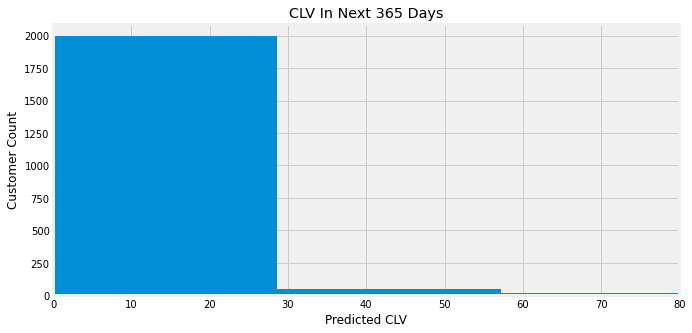

In [508]:
#Plot a histogram of our ltv predictions
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(ltv_predictions)
ax.set_xbound(0,80)
ax.set_title("CLV In Next 365 Days")
ax.set_ylabel("Customer Count")
ax.set_xlabel("Predicted CLV")
;

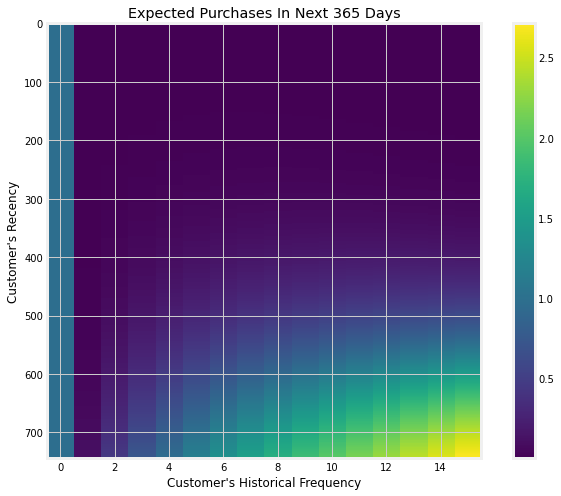

In [407]:
from lifetimes.plotting import plot_frequency_recency_matrix
fig = plt.figure(figsize=(10,8))
fig = plot_frequency_recency_matrix(bgf_2,T=365)
fig.set_title("Expected Purchases In Next 365 Days");
plt.savefig("visuals/expected_purchases_matrix.png")

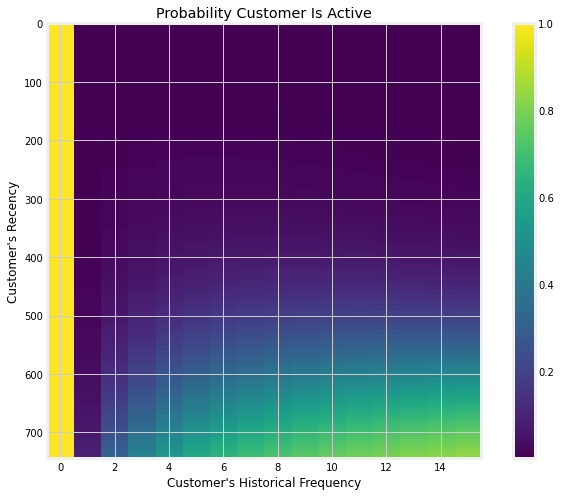

In [408]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(10,8))
fig = plot_probability_alive_matrix(bgf_2)
fig.set_title("Probability Customer Is Active");
plt.savefig("visuals/probability_active_matrix.png")

In [486]:
bgf_2.params_["alpha"]

2057.939543406805

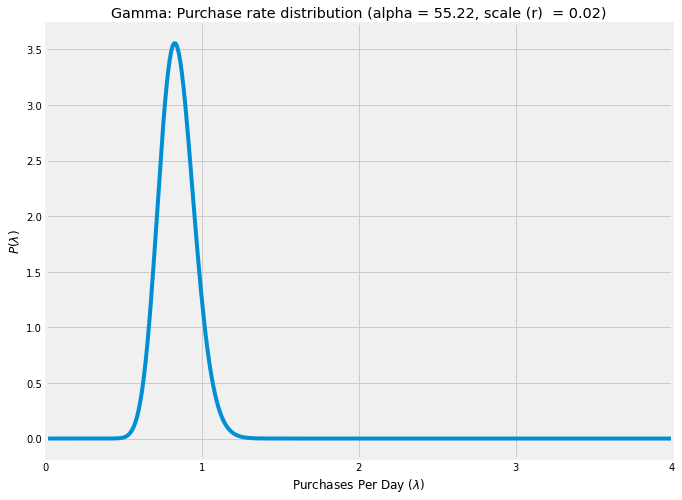

In [484]:
import scipy.stats as stats
fig, ax_gamma = plt.subplots(figsize = (10, 8))

x_gamma = np.linspace(0, 10, 1000)
y_gamma = stats.gamma.pdf(x_gamma, a=bgf_1.params_["alpha"], scale=bgf_1.params_["r"])
ax_gamma.plot(x_gamma, y_gamma, "-")
ax_gamma.set_title(f'Gamma: Purchase rate distribution (alpha = {bgf_1.params_["alpha"]:.2f}, scale (r)  = {bgf_1.params_["r"]:.2f})')
ax_gamma.set_xlabel(r"Purchases Per Day " '($\lambda$)')
ax_gamma.set_ylabel(r'$P(\lambda)$')
ax_gamma.set_xbound(0,4)
ax_gamma.set_xticks([0,1,2,3,4]);
plt.savefig("visuals/gamma_purchase_rate_dist.png")


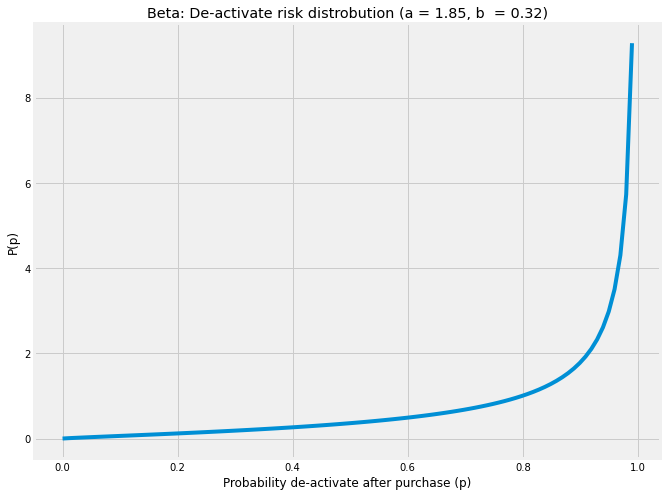

In [458]:

fig, ax_beta = plt.subplots(figsize = (10, 8))
x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf_1.params_["a"], b=bgf_1.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta: De-activate risk distrobution (a = {bgf_1.params_["a"]:.2f}, b  = {bgf_1.params_["b"]:.2f})')
ax_beta.set_xlabel("Probability de-activate after purchase (p)" )
ax_beta.set_ylabel('P(p)')
plt.savefig("visuals/beta_deactivate_risk_dist.png")


In [416]:
x_beta = np.linspace(0, 1, 100)
y_beta = stats.beta.pdf(x_beta, a=bgf_1.params_["a"], b=bgf_1.params_["b"])
ax_beta.plot(x_beta, y_beta, "-")
ax_beta.set_title(f'Beta distribution (a = {bgf_1.params_["a"]:.2f}, b  = {bgf_1.params_["b"]:.2f})')
ax_beta.set_xlabel('p')
ax_beta.set_ylabel('P(p)')
plt.show()

#### Pipelines
Train/Test eval
1. clean_transaction_csv
2. df_ch
3. df_ch_getdf
Final
1. clean_transaction_csv
2. summary
3. gg_model